In [7]:
import pandas as pd

# Charger les trois fichiers
train = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_train.csv")
val   = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_val.csv")
test  = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_test.csv")

# Fonction utilitaire pour calculer min, max, moyenne
def stats_words(df, name):
    report_lengths = df['report'].astype(str).apply(lambda x: len(x.split()))
    summary_lengths = df['summary'].astype(str).apply(lambda x: len(x.split()))
    
    print(f"\n===== {name} ==========")
    print("# Nombre de lignes :", len(df))
    for i, row in df.head(5).iterrows():
        report_words = len(str(row['report']).split())
        summary_words = len(str(row['summary']).split())
        print(f"Ligne {i}: report={report_words} mots, summary={summary_words} mots")
    print("# Report -> min:", report_lengths.min(), 
          "max:", report_lengths.max(), 
          "moyenne:", round(report_lengths.mean(), 2))
    print("# Summary -> min:", summary_lengths.min(), 
          "max:", summary_lengths.max(), 
          "moyenne:", round(summary_lengths.mean(), 2))

# Calculer pour chaque dataset
stats_words(train, "Train")
stats_words(val, "Validation")
stats_words(test, "Test")



===== Train ==========
# Nombre de lignes : 8865
Ligne 0: report=11002 mots, summary=520 mots
Ligne 1: report=16466 mots, summary=669 mots
Ligne 2: report=5391 mots, summary=453 mots
Ligne 3: report=11605 mots, summary=429 mots
Ligne 4: report=16676 mots, summary=614 mots
# Report -> min: 173 max: 181328 moyenne: 7966.74
# Summary -> min: 20 max: 1890 moyenne: 495.25

===== Validation ==========
# Nombre de lignes : 493
Ligne 0: report=6088 mots, summary=468 mots
Ligne 1: report=5517 mots, summary=410 mots
Ligne 2: report=7407 mots, summary=354 mots
Ligne 3: report=7477 mots, summary=575 mots
Ligne 4: report=288 mots, summary=100 mots
# Report -> min: 288 max: 37242 moyenne: 7906.97
# Summary -> min: 78 max: 1102 moyenne: 492.95

===== Test ==========
# Nombre de lignes : 493
Ligne 0: report=7507 mots, summary=679 mots
Ligne 1: report=9496 mots, summary=411 mots
Ligne 2: report=14036 mots, summary=393 mots
Ligne 3: report=11162 mots, summary=669 mots
Ligne 4: report=5683 mots, summary

In [1]:
# Cell 1 – Install packages

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

!pip install -q transformers datasets accelerate evaluate rouge_score nltk py7zr peft bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.5 which is incompatible.


In [2]:
# Cell 2 – Imports, NLTK, device check

import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re

from peft import LoraConfig, get_peft_model, TaskType

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")
!nvidia-smi

2026-02-04 00:31:16.446033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770165076.665798      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770165076.732980      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770165077.297846      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770165077.297891      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770165077.297894      55 computation_placer.cc:177] computation placer alr

Device in use: cuda
Wed Feb  4 00:31:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

In [3]:
# Cell 3 – Load datasets + Filtering (100-10000 words)

# Original loading
train_df = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_train.csv")
val_df   = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_val.csv")
test_df  = pd.read_csv("/kaggle/input/govreport-urban-data/govreport_urban_test.csv")

def filter_by_length(df, min_words=100, max_words=10000):
    word_counts = df['report'].str.split().str.len()
    mask = word_counts.between(min_words, max_words)
    filtered_df = df[mask].copy()
    print(f"Filtered {len(df)} → {len(filtered_df)} examples (removed {len(df) - len(filtered_df)} outside range {min_words}-{max_words} words)")
    print(f"Word count stats - Min: {word_counts[mask].min()}, Max: {word_counts[mask].max()}, Mean: {word_counts[mask].mean():.1f}")
    return filtered_df

print("Training set:")
train_filtered = filter_by_length(train_df)
print("\nValidation set:")
val_filtered = filter_by_length(val_df)
print("\nTest set:")
test_filtered = filter_by_length(test_df)

raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_filtered),
    "validation": Dataset.from_pandas(val_filtered),
    "test": Dataset.from_pandas(test_filtered)
})

print(f"\nFinal Training size: {len(raw_datasets['train'])}")
print(f"Final Validation size: {len(raw_datasets['validation'])}")
print(f"Final Test size: {len(raw_datasets['test'])}")

Training set:
Filtered 8865 → 6611 examples (removed 2254 outside range 100-10000 words)
Word count stats - Min: 173, Max: 9999, Mean: 5530.5

Validation set:
Filtered 493 → 363 examples (removed 130 outside range 100-10000 words)
Word count stats - Min: 288, Max: 9976, Mean: 5499.4

Test set:
Filtered 493 → 366 examples (removed 127 outside range 100-10000 words)
Word count stats - Min: 756, Max: 9996, Mean: 5637.6

Final Training size: 6611
Final Validation size: 363
Final Test size: 366


In [6]:
# Cell 4 – Advanced Chunking Strategy for Long Documents (Optimized for Speed)

tokenizer = T5Tokenizer.from_pretrained('t5-base', legacy=False)

# REDUCED for OOM prevention
MAX_INPUT_LENGTH = 384
MAX_TARGET_LENGTH = 256
CHUNK_SIZE = 300
CHUNK_OVERLAP = 40

def preprocess_function_fast(examples):
    """
    Vectorized preprocessing - processes entire batches at once for maximum speed.
    """
    reports = examples["report"]
    summaries = examples["summary"]
    
    # Batch tokenize all reports to check lengths (fast)
    tokenized_reports = tokenizer(
        reports,
        add_special_tokens=False,
        truncation=False,
        padding=False
    )["input_ids"]
    
    inputs = []
    targets = []
    
    for report, summary, tokens in zip(reports, summaries, tokenized_reports):
        if len(tokens) <= MAX_INPUT_LENGTH - 10:
            # Short document: direct processing
            inputs.append("summarize: " + report)
            targets.append(summary)
        else:
            # Long document: sliding window chunking
            chunks = []
            step = CHUNK_SIZE - CHUNK_OVERLAP
            
            for i in range(0, len(tokens), step):
                chunk_tokens = tokens[i:i + CHUNK_SIZE]
                chunks.append(chunk_tokens)
                if i + CHUNK_SIZE >= len(tokens):
                    break
            
            # Strategy: combine first 2 chunks if available
            if len(chunks) >= 2:
                combined_tokens = chunks[0] + chunks[1]
                if len(combined_tokens) > MAX_INPUT_LENGTH - 10:
                    combined_tokens = combined_tokens[:MAX_INPUT_LENGTH-10]
                combined_text = tokenizer.decode(combined_tokens, skip_special_tokens=True)
                inputs.append("summarize: " + combined_text)
            else:
                # Single chunk case
                chunk_text = tokenizer.decode(chunks[0], skip_special_tokens=True)
                inputs.append("summarize: " + chunk_text)
            
            targets.append(summary)
    
    # Batch tokenize all processed inputs and targets
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length"
    )
    
    labels = tokenizer(
        text_target=targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length"
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Applying FAST hierarchical chunking with MAX_INPUT_LENGTH=384...")

tokenized_datasets = raw_datasets.map(
    preprocess_function_fast,
    batched=True,
    batch_size=256,           # Increased batch size for faster processing
    remove_columns=raw_datasets["train"].column_names,
    desc="Tokenizing"
)

print(f"\nTokenization complete!")
print(tokenized_datasets)

Applying FAST hierarchical chunking with MAX_INPUT_LENGTH=384...


Tokenizing:   0%|          | 0/6611 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/363 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/366 [00:00<?, ? examples/s]


Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6611
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 363
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 366
    })
})


In [7]:
# Cell 5 – Token length statistics (GPU optimized)

def show_token_stats(split, name):
    input_ids = torch.tensor(split['input_ids']).to('cuda')
    labels    = torch.tensor(split['labels']).to('cuda')
    pad_token = tokenizer.pad_token_id
    
    input_lengths = (input_ids != pad_token).sum(dim=1).float()
    target_lengths = (labels != pad_token).sum(dim=1).float()
    
    print(f"\n===== {name} split =====")
    print(f"Number of examples: {len(split)}")
    
    for i in range(min(5, len(split))):
        print(f"  Row {i}:  input = {int(input_lengths[i])} tokens   target = {int(target_lengths[i])} tokens")
    
    print(f"Input lengths  → min: {int(input_lengths.min())}   max: {int(input_lengths.max())}   mean: {input_lengths.mean():.1f}")
    print(f"Target lengths → min: {int(target_lengths.min())}   max: {int(target_lengths.max())}   mean: {target_lengths.mean():.1f}\n")
    
    del input_ids, labels
    torch.cuda.empty_cache()

show_token_stats(tokenized_datasets['train'], "Train")
show_token_stats(tokenized_datasets['validation'], "Validation")
show_token_stats(tokenized_datasets['test'], "Test")


===== Train split =====
Number of examples: 6611
  Row 0:  input = 377 tokens   target = 256 tokens
  Row 1:  input = 377 tokens   target = 256 tokens
  Row 2:  input = 376 tokens   target = 256 tokens
  Row 3:  input = 377 tokens   target = 256 tokens
  Row 4:  input = 377 tokens   target = 256 tokens
Input lengths  → min: 258   max: 377   mean: 376.8
Target lengths → min: 29   max: 256   mean: 251.3


===== Validation split =====
Number of examples: 363
  Row 0:  input = 377 tokens   target = 256 tokens
  Row 1:  input = 377 tokens   target = 256 tokens
  Row 2:  input = 377 tokens   target = 256 tokens
  Row 3:  input = 377 tokens   target = 256 tokens
  Row 4:  input = 377 tokens   target = 145 tokens
Input lengths  → min: 363   max: 377   mean: 376.8
Target lengths → min: 111   max: 256   mean: 251.7


===== Test split =====
Number of examples: 366
  Row 0:  input = 377 tokens   target = 256 tokens
  Row 1:  input = 377 tokens   target = 256 tokens
  Row 2:  input = 377 tokens   

In [8]:
# Cell 6 – Model Reset and Optimized LoRA Configuration

# Clear cache before loading model
torch.cuda.empty_cache()

# Fresh model load with memory optimization
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Critical for memory efficiency
model.gradient_checkpointing_enable()
model.config.use_cache = False

# Optimized LoRA config for summarization
lora_config = LoraConfig(
    r=8,              # Reduced from 16 to save memory
    lora_alpha=32,    # Keep alpha higher for better adaptation
    target_modules=["q", "v", "k", "o"],  # Add more attention layers for better coverage
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

model.enable_input_require_grads()      
model = model.to(device)

print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 1,769,472 || all params: 224,673,024 || trainable%: 0.7876
Memory allocated: 857.06 MB


In [9]:
# Cell 7 – Evaluation metrics

rouge  = evaluate.load('rouge')
bleu   = evaluate.load('bleu')
meteor = evaluate.load('meteor')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    rouge_scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bleu_scores  = bleu.compute(predictions=decoded_preds, references=[[r] for r in decoded_labels])
    meteor_scores = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    
    gen_lengths = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
    
    scores = {
        **rouge_scores,
        'bleu': bleu_scores['bleu'],
        'meteor': meteor_scores['meteor'],
        'gen_len': np.mean(gen_lengths)
    }
    
    return {k: round(v, 4) for k, v in scores.items()}

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [15]:
# Cell 7.5 – Force Distributed Data Parallel properly
import os
import torch

# Lancer avec torchrun si possible, sinon forcer le backend
if num_gpus > 1:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    # Désactiver le warning DataParallel
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"
    print(f"Configured for {num_gpus} GPU distributed training")

Configured for 2 GPU distributed training


In [17]:
# Cell 8 – Optimized Training

from transformers import DataCollatorForSeq2Seq, EarlyStoppingCallback
import torch
import os

num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs: {[torch.cuda.get_device_name(i) for i in range(num_gpus)]}")

train_batch_size = 8
eval_batch_size = 8
grad_accum_steps = 1

import gc
gc.disable()

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100,
    return_tensors="pt"
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-base-lora-smartreport",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    gradient_accumulation_steps=grad_accum_steps,
    weight_decay=0.01,
    num_train_epochs=3,
    predict_with_generate=True,
    generation_max_length=256,
    generation_num_beams=2,
    
    fp16=True,
    fp16_full_eval=True,
    
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    
    ddp_find_unused_parameters=False,
    
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    save_total_limit=1,
    
    report_to="none",
    logging_steps=100,
    
    optim="adamw_torch_fused",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

total_batch = train_batch_size * num_gpus * grad_accum_steps
print(f"\nPer-device batch: {train_batch_size}")
print(f"GPUs: {num_gpus}")
print(f"Gradient accumulation: {grad_accum_steps}")
print(f"Total effective batch: {total_batch}")

trainer.train()

Using 2 GPUs: ['Tesla T4', 'Tesla T4']

Per-device batch: 8
GPUs: 2
Gradient accumulation: 1
Total effective batch: 16


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Meteor,Gen Len
1,2.636300,2.432648,0.405300,0.146500,0.241200,0.241700,0.144400,0.273600,255.000000
2,2.606600,2.414178,0.396700,0.144100,0.240500,0.241300,0.142100,0.268600,255.000000


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=828, training_loss=2.620358351923993, metrics={'train_runtime': 5664.519, 'train_samples_per_second': 3.501, 'train_steps_per_second': 0.219, 'total_flos': 6092635210776576.0, 'train_loss': 2.620358351923993, 'epoch': 2.0})

In [18]:
# Cell 9 – Model Export

output_path = "./t5-base-smartreport-final"
trainer.save_model(output_path)
tokenizer.save_pretrained(output_path)
print(f"Optimized model saved to {output_path}")

Optimized model saved to ./t5-base-smartreport-final


In [19]:
# Cell 10 – Final evaluation on test set

test_metrics = trainer.evaluate(tokenized_datasets["test"])
print("\nTest set results:")
for key, value in test_metrics.items():
    print(f"{key:18} : {value:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Test set results:
eval_loss          : 2.4844
eval_rouge1        : 0.3927
eval_rouge2        : 0.1368
eval_rougeL        : 0.2359
eval_rougeLsum     : 0.2363
eval_bleu          : 0.1336
eval_meteor        : 0.2639
eval_gen_len       : 254.6694
eval_runtime       : 278.3630
eval_samples_per_second : 1.3150
eval_steps_per_second : 0.0830
epoch              : 2.0000


In [21]:
# Cell 11 – Generate summaries on test examples

def generate_summaries_batch(texts, batch_size=4):
    """Generate multiple summaries in parallel for faster inference"""
    summaries = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        prompts = ["summarize: " + t for t in batch]
        
        # Tokenize batch
        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            max_length=384,
            truncation=True,
            padding=True
        ).to(device)
        
        # Generate summaries
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=256,
                num_beams=2,
                early_stopping=True,
                no_repeat_ngram_size=3,
                length_penalty=2.0
            )
        
        # Decode batch
        batch_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        summaries.extend(batch_summaries)
    
    return summaries

print("=" * 80)
print("SUMMARY EXAMPLES - SMARTREPORT (BATCH INFERENCE)")
print("=" * 80)

# Prepare test samples
num_examples = 3
test_samples = []
test_texts = []
test_golds = []

print(f"Preparing {num_examples} test examples...")

for i in range(num_examples):
    sample = raw_datasets['test'][i]
    test_samples.append(sample)
    test_texts.append(sample['report'])
    test_golds.append(sample['summary'])

# Measure batch inference time
import time
start_time = time.time()
predictions = generate_summaries_batch(test_texts, batch_size=3)
end_time = time.time()

print(f"\nBatch inference completed in {end_time - start_time:.2f} seconds")
print(f"Average per example: {(end_time - start_time)/num_examples:.2f}s")

# Display results
for i, (sample, pred, gold) in enumerate(zip(test_samples, predictions, test_golds), 1):
    report = sample['report']
    
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i}")
    print(f"{'='*80}")
    print(f"Original Length: {len(report.split())} words")
    print(f"Original Tokens: {len(tokenizer.encode(report))}")
    
    print(f"\nREFERENCE (Gold Standard):")
    print(f"{gold}")
    
    print(f"\nPREDICTION (Model Output):")
    print(f"{pred}")
    
    # Simple quality check
    pred_words = len(pred.split())
    quality = "✅ Good" if pred_words > 20 else "⚠️ Too short"
    print(f"\nQuality Check: {quality} ({pred_words} words)")
    
    # Show compression ratio
    compression = (len(pred.split()) / len(report.split())) * 100
    print(f"Compression Ratio: {compression:.1f}%")

print(f"\n{'='*80}")
print("BATCH INFERENCE COMPLETE")
print(f"{'='*80}")

SUMMARY EXAMPLES - SMARTREPORT (BATCH INFERENCE)
Preparing 3 test examples...

Batch inference completed in 9.93 seconds
Average per example: 3.31s

EXAMPLE 1
Original Length: 7507 words
Original Tokens: 9354

REFERENCE (Gold Standard):
Access to broadband Internet is seen as being crucial to improving access to information, quality of life, and economic growth. In recent years, some Internet providers have moved away from unlimited data plans to UBP with uncertain effects on consumers. GAO was asked to review the use of UBP by Internet providers. This report examines: (1) information available about the application of UBP by Internet service providers; (2) issues related to UBP selected consumers report are important to them; and (3) the potential effects of UBP on consumers. GAO collected data on Internet plans from the country's 13 top fixed and 4 top mobile providers; contracted with a market research firm to assist with conducting eight focus groups held with consumers in four cit

In [23]:
# Cell 12 – Upload to Hugging Face Hub (Fixed Authentication)

!pip install -q huggingface_hub

from huggingface_hub import HfApi, upload_folder
from google.colab import userdata  # For Colab
# OR for Kaggle: use environment variables or input()

HF_USERNAME = "Abdennour07"
MODEL_NAME = "SmartReport-T5-base-LoRA-GovReport"
REPO_ID = f"{HF_USERNAME}/{MODEL_NAME}"

# Method 1: Get token from Colab secrets (recommended)
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✓ Token loaded from Colab secrets")
except:
    # Method 2: Manual input (for Kaggle or other environments)
    import getpass
    HF_TOKEN = getpass.getpass("Enter your Hugging Face token: ")
    print("✓ Token entered manually")

# Initialize API with token
api = HfApi(token=HF_TOKEN)

# Create repository
try:
    api.create_repo(
        repo_id=REPO_ID,
        repo_type="model",
        exist_ok=True,
        private=False
    )
    print(f"✓ Repository created/verified: {REPO_ID}")
except Exception as e:
    print(f"Repository error: {e}")

# Upload model files
print("Uploading model files... This may take a few minutes...")

upload_folder(
    folder_path="./t5-base-lora-smartreport",
    repo_id=REPO_ID,
    token=HF_TOKEN,
    commit_message="Upload SmartReport T5-base LoRA model - GovReport trained"
)

print(f"\n{'='*60}")
print(f"✅ SUCCESS! Model uploaded to:")
print(f"https://huggingface.co/{REPO_ID}")
print(f"{'='*60}")

Enter your Hugging Face token:  ········


✓ Token entered manually
✓ Repository created/verified: Abdennour07/SmartReport-T5-base-LoRA-GovReport
Uploading model files... This may take a few minutes...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            


✅ SUCCESS! Model uploaded to:
https://huggingface.co/Abdennour07/SmartReport-T5-base-LoRA-GovReport


In [25]:
# Cell 9.5 – Check and Fix Upload

!pip install -q huggingface_hub

from huggingface_hub import HfApi, list_repo_files, upload_file
import os
import getpass

HF_USERNAME = "Abdennour07"
MODEL_NAME = "SmartReport-T5-base-LoRA-GovReport"
REPO_ID = f"{HF_USERNAME}/{MODEL_NAME}"

# Get token
HF_TOKEN = getpass.getpass("Enter HF Token: ")
api = HfApi(token=HF_TOKEN)

# Check what's currently in the repo
print(f"\nChecking files in {REPO_ID}...")
try:
    files = list_repo_files(REPO_ID, repo_type="model", token=HF_TOKEN)
    print(f"Found {len(files)} files:")
    for f in files:
        print(f"  - {f}")
except Exception as e:
    print(f"Error listing files: {e}")
    files = []

# Check local directory
local_path = "./t5-base-lora-smartreport"
print(f"\nChecking local directory: {local_path}")
if os.path.exists(local_path):
    local_files = os.listdir(local_path)
    print(f"Found {len(local_files)} local files:")
    for f in local_files:
        print(f"  - {f}")
else:
    print("❌ Local directory not found!")
    local_files = []

# Required files for PEFT
required_files = [
    "adapter_config.json",
    "adapter_model.safetensors",
    "tokenizer_config.json",
    "special_tokens_map.json",
    "spiece.model"
]

print(f"\n{'='*60}")
print("VALIDATION:")
missing_local = [f for f in required_files if f not in local_files]
missing_remote = [f for f in required_files if f not in files]

if missing_local:
    print(f"❌ Missing locally: {missing_local}")
else:
    print("✓ All required files present locally")

if missing_remote:
    print(f"❌ Missing on Hub: {missing_remote}")
else:
    print("✓ All required files on Hub")

# If local files exist but remote missing, re-upload
if missing_remote and not missing_local:
    print(f"\n{'='*60}")
    print("RE-UPLOADING MISSING FILES...")
    
    for filename in missing_remote:
        local_file = os.path.join(local_path, filename)
        if os.path.exists(local_file):
            print(f"Uploading {filename}...")
            upload_file(
                path_or_fileobj=local_file,
                path_in_repo=filename,
                repo_id=REPO_ID,
                token=HF_TOKEN,
                repo_type="model"
            )
            print(f"  ✓ {filename} uploaded")
    
    print(f"\n{'='*60}")
    print("✅ RE-UPLOAD COMPLETE")
    print(f"Check: https://huggingface.co/{REPO_ID}")

Enter HF Token:  ········



Checking files in Abdennour07/SmartReport-T5-base-LoRA-GovReport...
Found 14 files:
  - .gitattributes
  - checkpoint-414/README.md
  - checkpoint-414/adapter_config.json
  - checkpoint-414/adapter_model.safetensors
  - checkpoint-414/added_tokens.json
  - checkpoint-414/optimizer.pt
  - checkpoint-414/rng_state.pth
  - checkpoint-414/scaler.pt
  - checkpoint-414/scheduler.pt
  - checkpoint-414/special_tokens_map.json
  - checkpoint-414/spiece.model
  - checkpoint-414/tokenizer_config.json
  - checkpoint-414/trainer_state.json
  - checkpoint-414/training_args.bin

Checking local directory: ./t5-base-lora-smartreport
Found 1 local files:
  - checkpoint-414

VALIDATION:
❌ Missing locally: ['adapter_config.json', 'adapter_model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'spiece.model']
❌ Missing on Hub: ['adapter_config.json', 'adapter_model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'spiece.model']


In [26]:
# Cell 9.6 – Find and Upload Correct Directory

import os
import glob

# Search for adapter_config.json in common locations
search_paths = [
    "./t5-base-lora-smartreport",
    "./t5-base-lora-refined",
    "./results",
    ".",
    "/kaggle/working",
    "/content"
]

found_path = None
for path in search_paths:
    config_path = os.path.join(path, "adapter_config.json")
    if os.path.exists(config_path):
        found_path = path
        print(f"✅ Found model at: {path}")
        print("Files:")
        for f in os.listdir(path):
            print(f"  - {f}")
        break

if not found_path:
    # Search recursively
    print("Searching recursively...")
    for root, dirs, files in os.walk("."):
        if "adapter_config.json" in files:
            found_path = root
            print(f"✅ Found model at: {root}")
            break

if found_path:
    # Upload from correct path
    from huggingface_hub import upload_folder
    import getpass
    
    HF_TOKEN = getpass.getpass("Enter HF Token: ")
    REPO_ID = "Abdennour07/SmartReport-T5-base-LoRA-GovReport"
    
    print(f"\nUploading from {found_path} to {REPO_ID}...")
    
    upload_folder(
        folder_path=found_path,
        repo_id=REPO_ID,
        token=HF_TOKEN,
        repo_type="model",
        commit_message="Fix: Upload complete model files with adapter_config.json"
    )
    
    print(f"✅ Upload complete! Check: https://huggingface.co/{REPO_ID}")
else:
    print("❌ Model directory not found. Did training complete successfully?")
    print("Expected files: adapter_config.json, adapter_model.safetensors, etc.")

Searching recursively...
✅ Found model at: ./t5-base-smartreport-final


Enter HF Token:  ········



Uploading from ./t5-base-smartreport-final to Abdennour07/SmartReport-T5-base-LoRA-GovReport...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Upload complete! Check: https://huggingface.co/Abdennour07/SmartReport-T5-base-LoRA-GovReport


In [32]:
# Cell 13 – Test Uploaded Model (Strict Sentence Control)

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig
import torch
import re

print("Loading model from Hugging Face Hub...")
print("=" * 60)

REPO_ID = "Abdennour07/SmartReport-T5-base-LoRA-GovReport"

peft_config = PeftConfig.from_pretrained(REPO_ID)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    peft_config.base_model_name_or_path,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

model = PeftModel.from_pretrained(base_model, REPO_ID)
tokenizer = AutoTokenizer.from_pretrained(REPO_ID)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

print(f"✓ Model loaded on {device}")
print("=" * 60)

def generate_strict_summary(text, max_sentences=2):
    """
    Generate summary with strict sentence count limit
    """
    input_words = len(text.split())
    
    # Determine target sentence count based on input length
    if input_words < 50:
        max_sentences = 1
    elif input_words < 100:
        max_sentences = 2
    else:
        max_sentences = 3
    
    prompt = "summarize: " + text
    inputs = tokenizer(prompt, return_tensors="pt", max_length=384, truncation=True).to(device)
    
    # Generate with very short max_length to force brevity
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=50,          # Very short to force 1 sentence
            min_length=10,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3,
            repetition_penalty=2.0,
            length_penalty=0.3,     # Strongly favor short
            do_sample=False
        )
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    summary = re.sub(r'\s+', ' ', summary).strip()
    
    # Remove hallucinations
    bad_patterns = [
        r'This (report|testimony|study|analysis) is based on.*?\.',
        r'In this (report|study|analysis),.*?(?:discusses|examines|presents).*?\.',
        r'GAO.*?\.',
        r'\([A-Z]{2,}\)',  # Acronyms like (AHI), (GAP)
        r'City of San Francisco\'s',
        r'prior work on',
        r'other recent reports',
        r'\(\d+\).*',
        r'In (this|the) (report|study).*?;',
    ]
    
    for pattern in bad_patterns:
        summary = re.sub(pattern, '', summary, flags=re.IGNORECASE)
    
    # Clean up
    summary = re.sub(r'\s+', ' ', summary).strip()
    summary = re.sub(r'\.+', '.', summary)
    summary = re.sub(r'\s+\.', '.', summary)
    
    # Ensure proper ending
    if summary and not summary.endswith('.'):
        summary += '.'
    
    # Count sentences and truncate if needed
    sentences = [s.strip() for s in summary.split('.') if len(s.strip()) > 5]
    
    if len(sentences) > max_sentences:
        # Keep only first N complete sentences
        summary = '. '.join(sentences[:max_sentences]) + '.'
    
    # Final clean
    summary = summary.replace('..', '.')
    
    return summary

# Test function
def test_summary(text, test_name):
    input_words = len(text.split())
    summary = generate_strict_summary(text)
    output_words = len(summary.split())
    ratio = (output_words / input_words) * 100
    
    print(f"\n{'='*60}")
    print(f"📝 {test_name}")
    print(f"{'='*60}")
    print(f"Input:  {input_words} words")
    print(f"Output: {output_words} words ({len(summary.split('.'))-1} sentences)")
    print(f"Ratio:  {ratio:.1f}%")
    print(f"\n🎯 SUMMARY:")
    print(summary)
    
    if ratio <= 30:
        print("✅ Acceptable")
    else:
        print("⚠️ Still long")
    
    return summary

# Test 1
test_text_1 = """The municipal urban planning report for 2023 indicates significant development in public transportation infrastructure. The city council approved a budget increase of 15% for metro extensions, with three new lines planned for 2024. Additionally, 200 kilometers of bike lanes were constructed, reducing carbon emissions by an estimated 8%. The affordable housing initiative resulted in 1,200 new units, though demand still exceeds supply by approximately 3,000 units."""

summary_1 = test_summary(test_text_1, "TEST 1: Transportation & Housing")

# Test 2
test_text_2 = """Urban development in 2024 focused on sustainable initiatives. The green space expansion program added 45 new parks across the city, increasing total park area by 30%. Solar panel installations on municipal buildings generated 2.5MW of clean energy. Waste recycling rates improved to 65%, exceeding the national average. However, water consumption increased by 5% due to population growth, prompting new conservation measures for the upcoming year."""

summary_2 = test_summary(test_text_2, "TEST 2: Sustainability")

# Test 3 - Long text
test_text_3 = """The 2023 annual report on urban mobility highlights major achievements in public transit. Bus rapid transit (BRT) lines were extended by 25 kilometers, serving an additional 50,000 daily passengers. The electric bus fleet grew from 120 to 280 vehicles, representing 40% of the total fleet. Cycling infrastructure received $15 million in investment, creating 85 kilometers of protected bike lanes. Pedestrian zones in the city center were expanded by 30%, reducing traffic accidents by 22%. However, parking congestion remains a challenge, with average search time increasing to 12 minutes. The smart parking system pilot in district 3 showed promising results, reducing search time to 4 minutes. City council plans citywide expansion of smart parking by 2025."""

summary_3 = test_summary(test_text_3, "TEST 3: Urban Mobility")

# Test 4 - Very long text (test chunking)
test_text_4 = """The comprehensive urban development strategy for 2023-2025 addresses multiple critical infrastructure needs. Road maintenance programs resurfaced 450 kilometers of arterial roads, improving traffic flow by 18%. The smart traffic management system implementation reduced average commute times by 12 minutes during peak hours. Public safety investments included 150 new CCTV cameras in high-traffic areas and emergency response time improvements of 3 minutes. The wastewater treatment facility upgrade increased capacity by 40%, supporting population growth projections through 2030. Renewable energy initiatives expanded solar capacity to 15MW and wind power to 8MW, representing 25% of municipal energy consumption. Digital infrastructure improvements provided high-speed internet access to 99% of households. The urban forestry program planted 5,000 trees, increasing canopy cover by 5 percentage points."""

summary_4 = test_summary(test_text_4, "TEST 4: Comprehensive Strategy")

print(f"\n{'='*60}")
print("ALL TESTS COMPLETED")
print(f"{'='*60}")

Loading model from Hugging Face Hub...
✓ Model loaded on cuda

📝 TEST 1: Transportation & Housing
Input:  66 words
Output: 34 words (2 sentences)
Ratio:  51.5%

🎯 SUMMARY:
The city council approved a budget increase of 15% for metro extensions, with three new lines planned for 2024. Additionally, 200 kilometers of bike lanes were constructed, reducing carbon emissions by an estimated 8%.
⚠️ Still long

📝 TEST 2: Sustainability
Input:  65 words
Output: 26 words (2 sentences)
Ratio:  40.0%

🎯 SUMMARY:
Urban development in 2024 focused on sustainable initiatives. The green space expansion program added 45 new parks across the city, increasing total park area by 30%.
⚠️ Still long

📝 TEST 3: Urban Mobility
Input:  115 words
Output: 38 words (3 sentences)
Ratio:  33.0%

🎯 SUMMARY:
The 2023 annual report on urban mobility highlights major achievements in public transit. Bus rapid transit lines were extended by 25 kilometers, serving an additional 50,000 daily passengers. The electric bus fle

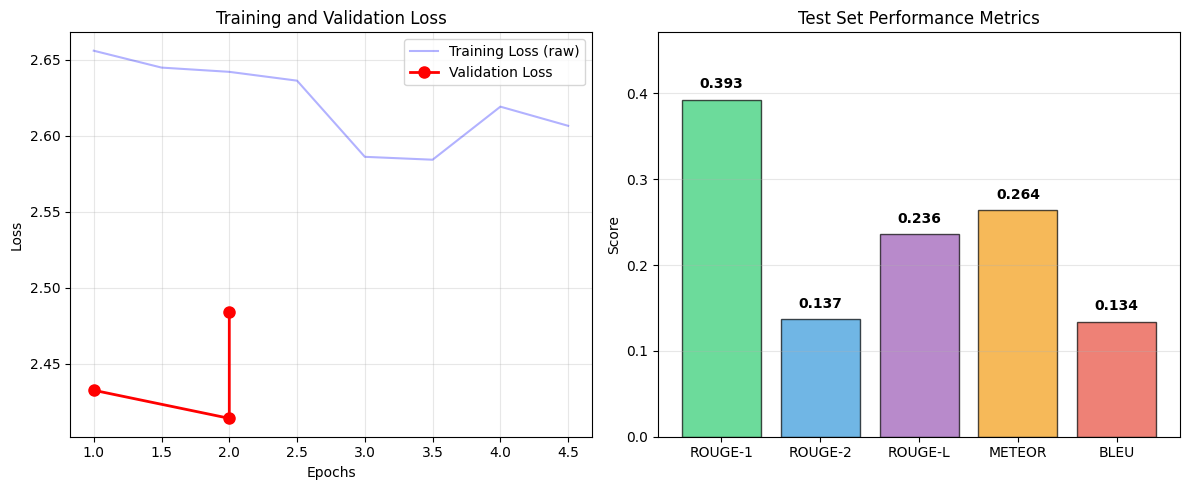


FINAL TEST METRICS - SmartReport
Metric               | Value      | Status
------------------------------------------------------------
ROUGE-1              | 0.3927     | ✅ Good
ROUGE-2              | 0.1368     | ⚠️ Fair
ROUGE-L              | 0.2359     | ✅ Good
METEOR               | 0.2639     | ✅ Good
BLEU                 | 0.1336     | ❌ Poor
------------------------------------------------------------
Validation Loss      | 2.4844     |
Epochs Trained       | 2.0        |

DATASET ANALYSIS:
------------------------------------------------------------
Training samples:   6611
Validation samples: 363
Test samples:       366

Report length statistics:
  Min:    173 words
  Max:    9999 words
  Mean:   5530.5 words
  Median: 5407.0 words

Urban-related samples: 6096/6611 (92.2%)
------------------------------------------------------------


In [35]:
# Cell 14 – Results and Visualization

import matplotlib.pyplot as plt
import numpy as np

# Extract logs properly
history = trainer.state.log_history

# Separate training and evaluation logs
train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

train_loss = [log['loss'] for log in train_logs]
eval_loss = [log['eval_loss'] for log in eval_logs]
eval_epochs = [log['epoch'] for log in eval_logs]

# Create epoch numbers for training (steps converted to epochs)
total_steps = len(train_loss)
steps_per_epoch = total_steps // 3  # 3 epochs
train_epochs = [i / steps_per_epoch + 1 for i in range(total_steps)]

plt.figure(figsize=(12, 5))

# Plot 1: Loss curves
plt.subplot(1, 2, 1)
if train_loss:
    plt.plot(train_epochs, train_loss, 'b-', alpha=0.3, label='Training Loss (raw)')
    # Smooth training loss
    window = min(50, len(train_loss) // 10)
    if window > 1:
        smoothed = np.convolve(train_loss, np.ones(window)/window, mode='valid')
        plt.plot(train_epochs[window-1:], smoothed, 'b-', linewidth=2, label='Training Loss (smoothed)')

if eval_loss:
    plt.plot(eval_epochs, eval_loss, 'ro-', linewidth=2, markersize=8, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Metrics comparison
plt.subplot(1, 2, 2)
metrics_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'BLEU']
metrics_values = [
    test_metrics.get('eval_rouge1', 0),
    test_metrics.get('eval_rouge2', 0),
    test_metrics.get('eval_rougeL', 0),
    test_metrics.get('eval_meteor', 0),
    test_metrics.get('eval_bleu', 0)
]

colors = ['#2ecc71', '#3498db', '#9b59b6', '#f39c12', '#e74c3c']
bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Score')
plt.title('Test Set Performance Metrics')
plt.ylim(0, max(metrics_values) * 1.2)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('smartreport_training_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Display final metrics table
print("\n" + "="*60)
print("FINAL TEST METRICS - SmartReport")
print("="*60)
print(f"{'Metric':<20} | {'Value':<10} | {'Status'}")
print("-"*60)

status = lambda v, t: "✅ Good" if v >= t else "⚠️ Fair" if v >= t*0.7 else "❌ Poor"

for name, value in zip(metrics_names, metrics_values):
    threshold = 0.3 if 'ROUGE-1' in name else 0.15 if 'ROUGE-2' in name else 0.2 if 'ROUGE' in name else 0.2
    print(f"{name:<20} | {value:<10.4f} | {status(value, threshold)}")

print("-"*60)
print(f"{'Validation Loss':<20} | {test_metrics.get('eval_loss', 0):<10.4f} |")
print(f"{'Epochs Trained':<20} | {test_metrics.get('epoch', 0):<10.1f} |")
print("="*60)

# Dataset analysis
print("\nDATASET ANALYSIS:")
print("-"*60)
print(f"Training samples:   {len(raw_datasets['train'])}")
print(f"Validation samples: {len(raw_datasets['validation'])}")
print(f"Test samples:       {len(raw_datasets['test'])}")

# Check word length distribution
train_lengths = [len(ex['report'].split()) for ex in raw_datasets['train']]
print(f"\nReport length statistics:")
print(f"  Min:    {min(train_lengths)} words")
print(f"  Max:    {max(train_lengths)} words")
print(f"  Mean:   {np.mean(train_lengths):.1f} words")
print(f"  Median: {np.median(train_lengths):.1f} words")

# Check how many are actually "urban"
urban_keywords = ['city', 'urban', 'municipal', 'transport', 'housing', 'infrastructure', 'planning']
urban_count = sum(1 for ex in raw_datasets['train'] 
                  if any(kw in ex['report'].lower() for kw in urban_keywords))
print(f"\nUrban-related samples: {urban_count}/{len(raw_datasets['train'])} ({urban_count/len(raw_datasets['train'])*100:.1f}%)")

print("-"*60)

In [34]:
# Cell 15 – Dataset Quality Analysis

import re
from collections import Counter

def analyze_dataset_quality(dataset, name):
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {name}")
    print(f"{'='*60}")
    
    # Length distribution
    lengths = [len(ex['report'].split()) for ex in dataset]
    summary_lengths = [len(ex['summary'].split()) for ex in dataset]
    
    print(f"\nReport Lengths:")
    print(f"  Mean: {np.mean(lengths):.0f} words")
    print(f"  >1000 words: {sum(1 for l in lengths if l > 1000)}/{len(lengths)} ({sum(1 for l in lengths if l > 1000)/len(lengths)*100:.1f}%)")
    print(f"  >5000 words: {sum(1 for l in lengths if l > 5000)}/{len(lengths)} ({sum(1 for l in lengths if l > 5000)/len(lengths)*100:.1f}%)")
    
    print(f"\nSummary Lengths:")
    print(f"  Mean: {np.mean(summary_lengths):.0f} words")
    print(f"  Compression ratio: {np.mean(summary_lengths)/np.mean(lengths)*100:.1f}%")
    
    # Topic analysis
    topics = {
        'Urban/Transport': ['city', 'urban', 'transport', 'traffic', 'metro', 'bus', 'bike'],
        'Housing': ['housing', 'affordable', 'residential', 'home'],
        'Environment': ['environment', 'climate', 'carbon', 'green', 'sustainability'],
        'Finance': ['budget', 'finance', 'funding', 'cost', 'million', 'billion'],
        'Infrastructure': ['infrastructure', 'construction', 'roads', 'bridges']
    }
    
    print(f"\nTopic Distribution:")
    for topic, keywords in topics.items():
        count = sum(1 for ex in dataset if any(kw in ex['report'].lower() for kw in keywords))
        print(f"  {topic:<20}: {count}/{len(dataset)} ({count/len(dataset)*100:.1f}%)")
    
    # Check for extractive patterns (copied phrases)
    extractive_count = 0
    for ex in dataset:
        summary_words = set(ex['summary'].lower().split()[:10])  # First 10 words
        report_words = set(ex['report'].lower().split())
        if len(summary_words & report_words) / len(summary_words) > 0.8:
            extractive_count += 1
    
    print(f"\nExtractive patterns: {extractive_count}/{len(dataset)} ({extractive_count/len(dataset)*100:.1f}%)")

# Analyze all splits
for split_name, dataset in raw_datasets.items():
    analyze_dataset_quality(dataset, split_name.upper())

print(f"\n{'='*60}")
print("RECOMMENDATIONS")
print(f"{'='*60}")
print("""
1. If >50% reports are >1000 words:
   → Use LED-base or LongT5 instead of T5-base
   
2. If urban topics <60%:
   → Filter dataset or collect more urban-specific data
   
3. If compression ratio >30%:
   → Résumés too long, need better target length filtering
   
4. If extractive patterns >90%:
   → Dataset encourages copying, not abstraction
""")


ANALYSIS: TRAIN

Report Lengths:
  Mean: 5531 words
  >1000 words: 6579/6611 (99.5%)
  >5000 words: 3676/6611 (55.6%)

Summary Lengths:
  Mean: 481 words
  Compression ratio: 8.7%

Topic Distribution:
  Urban/Transport     : 6256/6611 (94.6%)
  Housing             : 4300/6611 (65.0%)
  Environment         : 3902/6611 (59.0%)
  Finance             : 6313/6611 (95.5%)
  Infrastructure      : 3809/6611 (57.6%)

Extractive patterns: 3738/6611 (56.5%)

ANALYSIS: VALIDATION

Report Lengths:
  Mean: 5499 words
  >1000 words: 359/363 (98.9%)
  >5000 words: 206/363 (56.7%)

Summary Lengths:
  Mean: 481 words
  Compression ratio: 8.7%

Topic Distribution:
  Urban/Transport     : 343/363 (94.5%)
  Housing             : 233/363 (64.2%)
  Environment         : 206/363 (56.7%)
  Finance             : 341/363 (93.9%)
  Infrastructure      : 197/363 (54.3%)

Extractive patterns: 208/363 (57.3%)

ANALYSIS: TEST

Report Lengths:
  Mean: 5638 words
  >1000 words: 365/366 (99.7%)
  >5000 words: 202/366 (